In [6]:
import h5py
import os
import glob

from astropy import constants as const
from astropy import units as u

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xray_binary_utils import stellar, compas_utils

from typing import Tuple
from collections import defaultdict

In [7]:
COMPAS_DIR_PATH: str = '/home/maya/Workspace/COMPAS'

In [8]:
AU: np.float64 = np.float64(149597870700.) # m
HOURS_IN_YEAR: np.float64 = np.float64(8765.81277)

In [9]:
G: np.float64 = const.G.value
SUNMASS: np.float64 = const.M_sun.to(u.kg).value

SUNRADIUS: np.float64 = const.R_sun.to(u.km).value
SUNLUMINOSITY: np.float64 = const.L_sun.to('erg/s').value
c: np.float64 = const.c.to('m/s').value

AU_TO_M: np.float64 = const.au.to(u.m).value
HOURS_IN_YEAR: np.float64 = u.year.to(u.hour)
SECONDS_IN_YEAR: np.float64 = u.year.to(u.second)

$T=2\pi\sqrt{\frac{a^3}{G(M_1+M_2)}}$

$T=\frac{2\pi a}{v_{orb}}$

$a=\frac{T v_{orb}}{2\pi}$

In [10]:
def period(a: np.float64,
           mass1: np.float64,
           mass2: np.float64) -> np.float64:
       """Calculates period for given semimajor axis using Kepler's law

       Args:
           a (np.float64): semimajor axis in AU
           mass1 (np.float64): first mass in sunmass
           mass2 (np.float64): second mass in sunmass

       Returns:
           [np.float64]: period in hours
       """
       mass1_si: np.float64 = mass1*SUNMASS
       mass2_si: np.float64 = mass2*SUNMASS
       
       return 2*np.pi*np.sqrt(np.power(a*AU, 3)/(G*(mass1_si+mass2_si)))/3600.

## Accretion disk luminosity

### Luminosity and accretion rate limits

Eddington's luminosity -- a theoretical limit of stellar luminosity assuming uniform flux. Can be approximated by the following formula, with M as the star's mass in sunmasses:

$L_{Edd}\ [L_\odot]=3.2\cdot10^4\cdot M\ [M_\odot]$

In [11]:
def eddington_luminosity(mass: np.float64) -> np.float64:
    """Eddington luminosity for the given mass

    Args:
        mass (np.float64): mass in sunmass

    Returns:
        np.float64: eddington luminosity in sun luminosities
    """
    return np.float64(3.2*1e4*mass)

Theoretical limit to accretion rate, given by the formula:

$\dot{M}_{Edd}=\frac{L_{Edd}}{\epsilon c^2}$

where $\epsilon=0.1$ in the thin disk approximation

In [12]:
def eddington_rate(ledd: np.float64,
                   epsilon: np.float64 = np.float64(.1)) -> np.float64:
    """Calculates the eddington rate for given eddington luminosity

    Args:
        ledd (np.float64): eddington luminosity in solar luminosities
        epsilon (np.float64, optional): [description]. Defaults to np.float64(.1).

    Returns:
        np.float64: eddington rate in sunmass/year
    """

    si_ledd: np.float64 = ledd * SUNLUMINOSITY
    si_medd: np.float64 = si_ledd/(epsilon * np.power(c, 2)) # kg / s

    return si_medd * SECONDS_IN_YEAR / SUNMASS

### LMXB x-ray luminosities

The formulas from luminosities were taken from ().

For LMXBs with BH accretors and their orbital period P:

$L_x=\eta_{bol}\epsilon\times min\Bigg[2\times L_{Edd}, 3\times L_{Edd}\Big(\frac{P}{10h}\Big)\Bigg]$

$\eta_{bol}$ -- factor converting from the bolometric luminosity to the x-ray luminosity. For BH we assume $\eta_{bol}=0.8$

$\epsilon$ -- conversion efficiency of gravitational binding energy to radiation. For BH we assume $\epsilon=0.5$

In [13]:
def bh_x_ray_luminosity(donor_mass: np.float64,
                        accretor_mass: np.float64,
                        a: np.float64,
                        eta_bol: np.float64 = np.float64(0.8),
                        epsilon: np.float64 = np.float64(0.5)) -> np.float64:
    """X-ray luminosity for LMXB with BH accretor

    Args:
        donor_mass (np.float64): donor's mass in sunmass
        accretor_mass (np.float64): accretor's (BH's) mass in sunmass
        a (np.float64): semimajor axis in AU
        eta_bol (np.float64, optional): factor converting from the bolometric luminosity to x-ray. Defaults to np.float64(0.8).
        epsilon (np.float64, optional): conversion efficiency of gravitational binding energy to radiation. Defaults to np.float64(0.5).

    Returns:
        np.float64: x-ray luminosity in solar luminosities
    """
    ledd: np.float64 = eddington_luminosity(accretor_mass) # sun luminosity
        
    p: np.float64 = period(a, donor_mass, accretor_mass)
        
    return eta_bol * epsilon * np.min([2. * ledd, 3. * ledd * (p / 10)])

For LMXBs with NS accretors:

$L_x=\eta_{bol}\epsilon\times min\Bigg[2\times L_{Edd}, \frac{GM_a\dot{M}^2_{Edd}}{R_a\dot{M}_d}\Bigg

For NS, the factors are assumed to be as follows:

$\eta_{bol}=0.55$

$\epsilon=1.$

In [14]:
def ns_x_ray_luminosity(accretor_mass: np.float64,
                        accretor_radius: np.float64,
                        donor_mass_rate: np.float64,
                        eta_bol: np.float64 = np.float64(0.55),
                        epsilon: np.float64 = np.float64(1.)) -> np.float64:
    """X-ray luminosity for LMXB with NS accretor

    Args:
        accretor_mass (np.float64): accretor's mass in solar masses
        accretor_radius (np.float64): accretor's radius in solar radii
        donor_mass_rate (np.float64): donor's mass loss rate in solar masses/yr
        eta_bol (np.float64, optional): factor converting the bolometric luminosity to x-ray luminosity. Defaults to np.float64(0.55).
        epsilon (np.float64, optional): conversion efficiency of gravitational binding energy to radiation. Defaults to np.float64(1.).

    Returns:
        np.float64: x-ray luminosity in solar luminosities
    """


    def critical_rate_luminosity(accretor_mass: np.float64,
                                 ledd: np.float64,
                                 accretor_radius: np.float64,
                                 donor_mass_rate: np.float64) -> np.float64:
        """[summary]

        Args:
            accretor_mass (np.float64): accretor's mass in solar masses
            ledd (np.float64): eddington's luminosity in solar luminosities
            accretor_radius (np.float64): accretor's radius in solar radii
            donor_mass_rate (np.float64): donor's mass loss rate in solar masses/yr

        Returns:
            np.float64: [description]
        """

        si_acc_mass: np.float64 = accretor_mass * SUNMASS
        si_acc_radius: np.float64 = accretor_radius * SUNRADIUS
        si_donor_mass_rate: np.float64 = donor_mass_rate * SUNMASS / SECONDS_IN_YEAR # kg / s

        medd: np.float64 = eddington_rate(ledd) # sunmass / yr
        si_medd: np.float64 = medd * SUNMASS / SECONDS_IN_YEAR # kg / s

        si_results = G * si_acc_mass * np.power(si_medd, 2) / (si_acc_radius * si_donor_mass_rate) # erg / s

        return si_results / SUNLUMINOSITY


    ledd: np.float64 = eddington_luminosity(accretor_mass)
    
    return eta_bol * epsilon * np.min([2. * ledd,
                                      critical_rate_luminosity(accretor_mass,
                                                               ledd,
                                                               accretor_radius,
                                                               donor_mass_rate)])

## Calculate luminosities

In [15]:
def is_accreting_onto_co(datum: np.array, donor_ind: int, acceptor_ind: int, ind: int) -> bool:
        """Is the accretion occuring onto a compact object (neutron star or a black hole)
        with the donor being a main sequence star

        Args:
            datum (np.array): simulation data from COMPAS
            donor_ind (int): donor's index (1 or 2)
            acceptor_ind (int): acceptor's index (1 or 2)
            ind (int): index of the datarow that's being checked

        Returns:
            bool: accretion occurring from a MS star onto a compact object
        """
        
        if donor_ind not in [1, 2] or acceptor_ind not in [1, 2]:
                raise ValueError("donor_ind/acceptor_ind must be 1 or 2")
        
        return stellar.is_compact_object(datum[f'Stellar_Type({acceptor_ind})'][ind]) and \
            stellar.is_main_sequence(datum[f'Stellar_Type({donor_ind})'][ind]) and \
    datum[f'dmMT({acceptor_ind})'][ind] > 0.0

In [16]:
from typing import Optional

def accretion_data_to_numpy(output_file: h5py.File) -> Optional[np.array]:
    """Read's the output file from COMPAS and computes an array containing data about accretion events

    Args:
        output_file (h5py.File): output data from the COMPAS simulation

    Returns:
        Optional[np.array]: data with accretion events
    """
    accretion_indices = list(set(np.concatenate([np.flatnonzero(output_file[f'dmMT(1)']),
                                                 np.flatnonzero(output_file[f'dmMT(2)'])])))
    
    result = []

    if len(accretion_indices) == 0:
        return None
    
    donor_mass = -1
    donor_type = -1
    acceptor_type = -1
    
    for ind in accretion_indices:
        
        luminosity = None
        
        # 2 is the acceptor
        if is_accreting_onto_co(output_file, 1, 2, ind):
            donor_mass = output_file['Mass(1)'][ind]
        
            start_donor_mass = output_file['Mass(1)'][0]
            start_acceptor_mass = output_file['Mass(2)'][0]
            
            donor_type = output_file['Stellar_Type(1)'][ind]
            acceptor_type = output_file['Stellar_Type(2)'][ind]
            
            accretion_rate: np.float64 = output_file['dmMT(2)'][ind]/(output_file['dT'][ind]*1e6)


            # Black hole
            if donor_type == 14:
                luminosity: np.float64 = bh_x_ray_luminosity(donor_mass = donor_mass,
                                                             acceptor_mass = output_file['Mass(2)'][ind],
                                                             a = output_file['SemiMajorAxis'][ind])
            else:
                luminosity: np.float64 = ns_x_ray_luminosity(accretor_mass = output_file['Mass(2)'][ind],
                                                             accretor_radius = output_file['Radius(2)'][ind],
                                                             donor_mass_rate = accretion_rate)


        # 1 is the donor
        elif is_accreting_onto_co(output_file, 2, 1, ind):
            donor_mass = output_file['Mass(2)'][ind]
            
            start_donor_mass = output_file['Mass(2)'][0]
            start_acceptor_mass = output_file['Mass(1)'][0]
            
            donor_type = output_file['Stellar_Type(2)'][ind]
            acceptor_type = output_file['Stellar_Type(1)'][ind]
            
            accretion_rate: np.float64 = output_file['dmMT(1)'][ind]/(output_file['dT'][ind]*1e6)

            # Black hole
            if donor_type == 14:
                luminosity: np.float64 = bh_x_ray_luminosity(donor_mass = donor_mass,
                                                             acceptor_mass = output_file['Mass(1)'][ind],
                                                             a = output_file['SemiMajorAxis'][ind])
            else:
                luminosity: np.float64 = ns_x_ray_luminosity(accretor_mass = output_file['Mass(1)'][ind],
                                                             accretor_radius = output_file['Radius(1)'][ind],
                                                             donor_mass_rate = accretion_rate)
            
        if luminosity:
            
            time = np.sum(output_file['dT'][:ind])
            
            result.append([start_donor_mass, start_acceptor_mass, 
                           donor_mass, donor_type, acceptor_type, luminosity,
                           time, time + output_file['dT'][ind]])
            
    return result

In [17]:
def process_all_files(output_files_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Process all output files from COMPAS

    Returns:
        pd.DataFrame: dataframe with all accretion data for LMXBs and HMXBs
    """
    
    lmxb_array = []
    hmxb_array = []
    
    for f in glob.glob(f'{output_files_path}/BSE_Detailed_Output_*.h5'):
        try:
            acc_data = accretion_data_to_numpy(h5py.File(f, 'r'))
            if len(acc_data) == 0:
                print(f'Removing {f}')
                os.remove(f)
                continue

            if acc_data[0][2]>=3.0:
                hmxb_array.extend(acc_data)
            else:
                lmxb_array.extend(acc_data)
                
        except Exception as e:
            print(f'{e} for {f}')
            continue
            
    lmxb = pd.DataFrame(lmxb_array,
                        columns=['start_donor_mass', 'start_acceptor_mass',
                                 'donor_mass', 'donor_stellar_type', 'acceptor_stellar_type', 'luminosity',
                                 'start_time', 'end_time'])
    hmxb = pd.DataFrame(hmxb_array,
                        columns=['start_donor_mass', 'start_acceptor_mass',
                                 'donor_mass', 'donor_stellar_type', 'acceptor_stellar_type', 'luminosity',
                                 'start_time', 'end_time'])
    
        
    return lmxb, hmxb

In [18]:
lmxb, hmxb = process_all_files('0_01/COMPAS_Output/Detailed_Output');

'Unable to open object (addr overflow, addr = 17496, size = 1408, eoa = 2048)' for 0_01/COMPAS_Output/Detailed_Output/BSE_Detailed_Output_194649.h5


In [19]:
xb = pd.concat([lmxb, hmxb])

In [20]:
print(f'LMXB max time: {lmxb["end_time"].max()}')
print(f'HMXB max time: {hmxb["end_time"].max()}')

LMXB max time: 14642.031437075833
HMXB max time: 3839.214542187462


In [21]:
lmxb_sorted = lmxb.sort_values(by=['end_time', 'start_time'])
hmxb_sorted = hmxb.sort_values(by=['end_time', 'start_time'])
xb_sorted = xb.sort_values(by=['end_time', 'start_time'])

In [22]:
lmxb_ages = len(lmxb_sorted['end_time'].unique())
hmxb_ages = len(hmxb_sorted['end_time'].unique())
xb_ages = len(xb_sorted['end_time'].unique())

print(f'Timesteps for LMXBs: {lmxb_ages}')
print(f'Timesteps for HMXBs: {hmxb_ages}')
print(f'Timesteps for all XBs: {xb_ages}')

Timesteps for LMXBs: 15352
Timesteps for HMXBs: 8561
Timesteps for all XBs: 23913


In [23]:
lmxb_sorted_ns = lmxb_sorted.loc[lmxb_sorted['acceptor_stellar_type']==13]
lmxb_sorted_bh = lmxb_sorted.loc[lmxb_sorted['acceptor_stellar_type']==14]

hmxb_sorted_ns = hmxb_sorted.loc[hmxb_sorted['acceptor_stellar_type']==13]
hmxb_sorted_bh = hmxb_sorted.loc[hmxb_sorted['acceptor_stellar_type']==14]

xb_sorted_ns = xb_sorted.loc[xb_sorted['acceptor_stellar_type']==13]
xb_sorted_bh = xb_sorted.loc[xb_sorted['acceptor_stellar_type']==14]

def calculate_xb_luminosity(df):
    ages = []
    values = []
    
    for end_time in df['end_time'].values:
        
        ages.append(end_time)
        values.append(df.loc[(df['end_time']>=end_time) & (df['start_time']<=end_time)]['luminosity'].sum())
        
    return ages, values
    
lmxb_ns_ages, lmxb_ns_values = calculate_xb_luminosity(lmxb_sorted_ns)
lmxb_bh_ages, lmxb_bh_values = calculate_xb_luminosity(lmxb_sorted_bh)
lmxb_ages, lmxb_values = calculate_xb_luminosity(lmxb_sorted)

hmxb_ns_ages, hmxb_ns_values = calculate_xb_luminosity(hmxb_sorted_ns)
hmxb_bh_ages, hmxb_bh_values = calculate_xb_luminosity(hmxb_sorted_bh)
hmxb_ages, hmxb_values = calculate_xb_luminosity(hmxb_sorted)

xb_ns_ages, xb_ns_values = calculate_xb_luminosity(xb_sorted_ns)
xb_bh_ages, xb_bh_values = calculate_xb_luminosity(xb_sorted_bh)
xb_ages, xb_values = calculate_xb_luminosity(xb_sorted)

# Luminosity over time

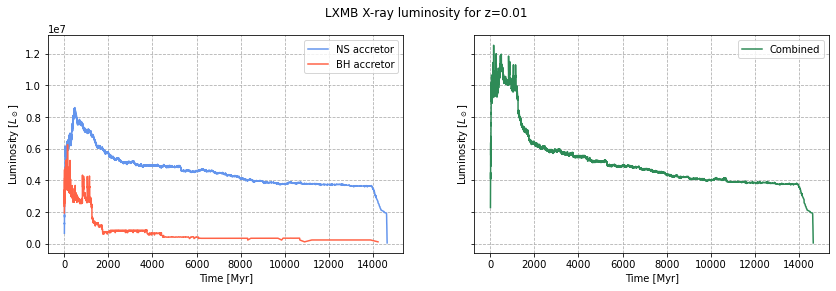

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 4), sharey=True)

fig.suptitle('LXMB X-ray luminosity for z=0.01')

def plot_luminosities(ax, dataframes, labels, colors):
    for df_tuple, label, color in zip(dataframes, labels, colors): 
        ages_df, values_df = df_tuple
        ax.plot(ages_df[:], values_df[:], label = label, color=color)
    ax.grid(linestyle = '--')
    ax.set_xlabel('Time [Myr]')
    ax.set_ylabel('Luminosity [$L_\odot$]')
    ax.legend()
    
plot_luminosities(ax[0],
                  [(lmxb_ns_ages, lmxb_ns_values),
                   (lmxb_bh_ages, lmxb_bh_values)],
                  ['NS accretor', 'BH accretor'],
                  ['cornflowerblue', 'tomato'])
plot_luminosities(ax[1], [(lmxb_ages, lmxb_values)], ['Combined'], ['seagreen'])

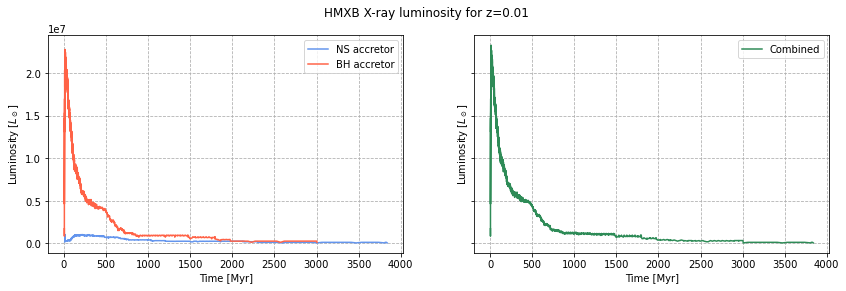

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 4), sharey=True)

fig.suptitle('HMXB X-ray luminosity for z=0.01')

plot_luminosities(ax[0],
                  [(hmxb_ns_ages, hmxb_ns_values),
                   (hmxb_bh_ages, hmxb_bh_values)],
                  ['NS accretor', 'BH accretor'],
                  ['cornflowerblue', 'tomato'])
plot_luminosities(ax[1], [(hmxb_ages, hmxb_values)], ['Combined'], ['seagreen'])

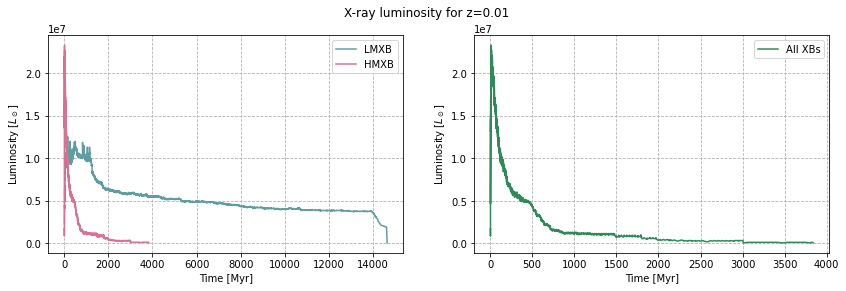

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))

fig.suptitle('X-ray luminosity for z=0.01')

plot_luminosities(ax[0],
                  [(lmxb_ages, lmxb_values),
                   (hmxb_ages, hmxb_values)],
                  ['LMXB', 'HMXB'],
                  ['cadetblue', 'palevioletred'])
plot_luminosities(ax[1], [(hmxb_ages, hmxb_values)], ['All XBs'], ['seagreen'])

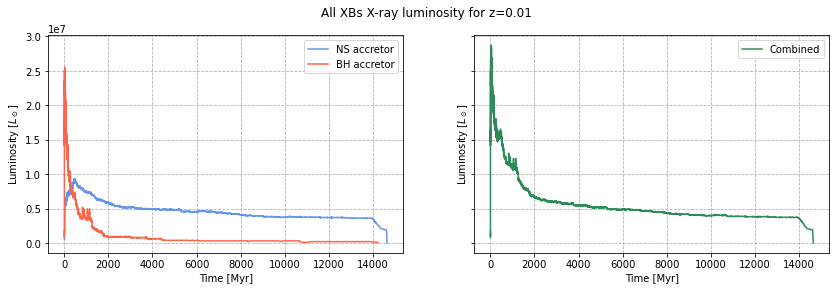

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 4), sharey=True)

fig.suptitle('All XBs X-ray luminosity for z=0.01')

plot_luminosities(ax[0],
                  [(xb_ns_ages, xb_ns_values),
                   (xb_bh_ages, xb_bh_values)],
                  ['NS accretor', 'BH accretor'],
                  ['cornflowerblue', 'tomato'])
plot_luminosities(ax[1], [(xb_ages, xb_values)], ['Combined'], ['seagreen'])

# Statistics

## NS accretor vs BH accretor

In [28]:
def count_values_for_timestep(df, timestep):
    return df.loc[(df['end_time']>=timestep) & (df['start_time']<=timestep)]['donor_mass'].count()

In [29]:
def plot_statistics(stat_fun, sorted_df, sorted_df_ns, sorted_df_bh):
    timesteps = np.linspace(0, sorted_df['end_time'].max(), 100)
    counts = [stat_fun(sorted_df, x) for x in timesteps]

    ns_counts = [stat_fun(sorted_df_ns, x) for x in timesteps]
    bh_counts = [stat_fun(sorted_df_bh, x) for x in timesteps]

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18, 4))

    ax[0].plot(timesteps, counts, label='all LMXBs', color='seagreen')
    ax[0].grid(linestyle='--')
    ax[0].legend()
    ax[0].set_xlabel('Time [Myr]')

    ax[1].plot(timesteps, ns_counts, label='NS accretor', color='cornflowerblue')
    ax[1].plot(timesteps, bh_counts, label='BH accretor', color='tomato')
    ax[1].grid(linestyle='--')
    ax[1].legend()
    ax[1].set_xlabel('Time [Myr]')

    ax[2].plot(timesteps, bh_counts, label='BH accretor', color='tomato')
    ax[2].grid(linestyle='--')
    ax[2].legend()
    ax[2].set_xlabel('Time [Myr]')

Text(0.5, 0.98, 'Number of all XBs for=0.02')

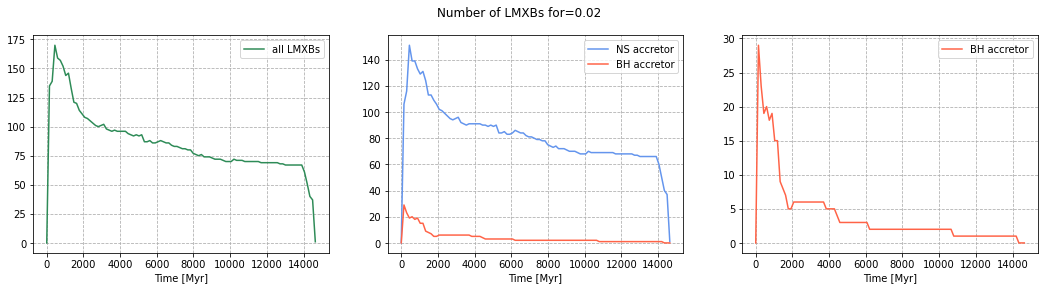

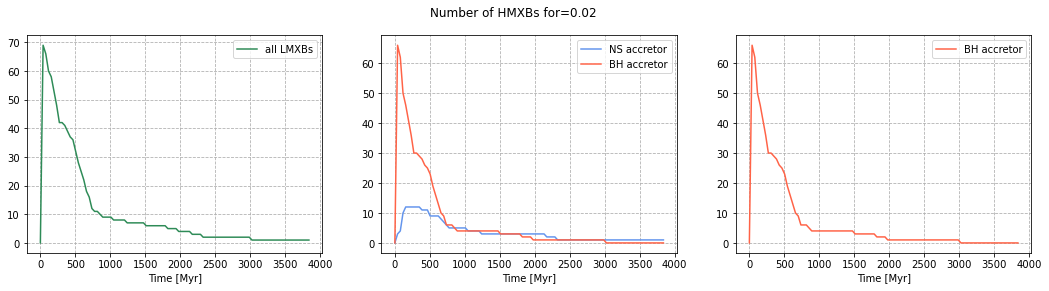

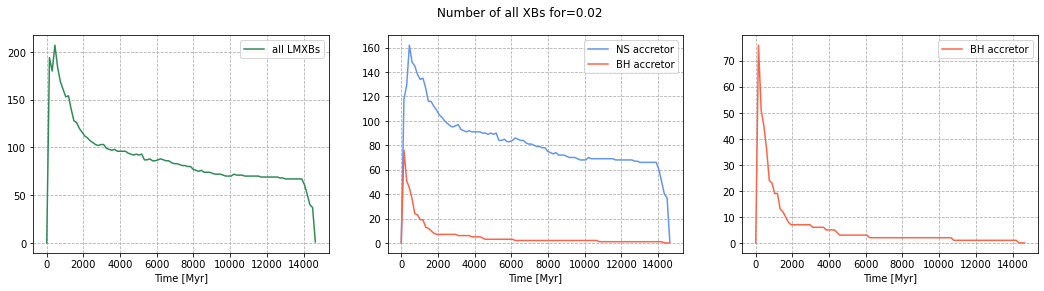

In [30]:
plot_statistics(count_values_for_timestep, lmxb_sorted, lmxb_sorted_ns, lmxb_sorted_bh)
plt.suptitle(f'Number of LMXBs for=0.02')

plot_statistics(count_values_for_timestep, hmxb_sorted, hmxb_sorted_ns, hmxb_sorted_bh)
plt.suptitle(f'Number of HMXBs for=0.02')

plot_statistics(count_values_for_timestep, xb_sorted, xb_sorted_ns, xb_sorted_bh)
plt.suptitle(f'Number of all XBs for=0.02')

Text(0.5, 0.98, 'Median overall X-ray luminosity [$L_\\odot$] for z=0.01')

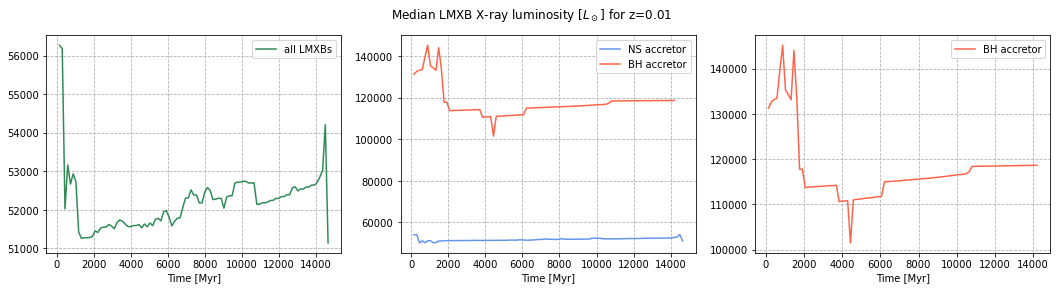

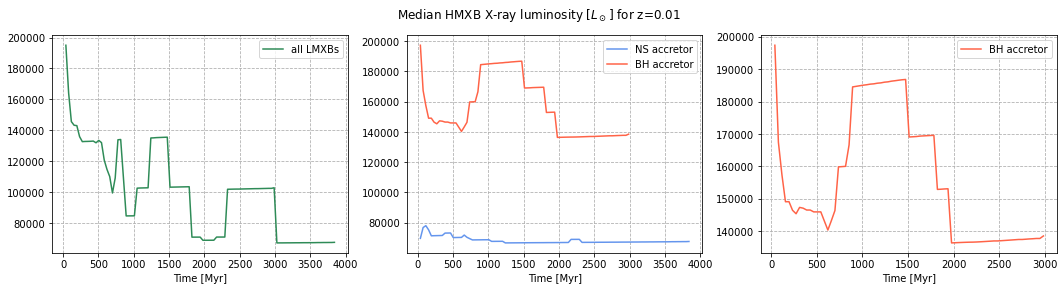

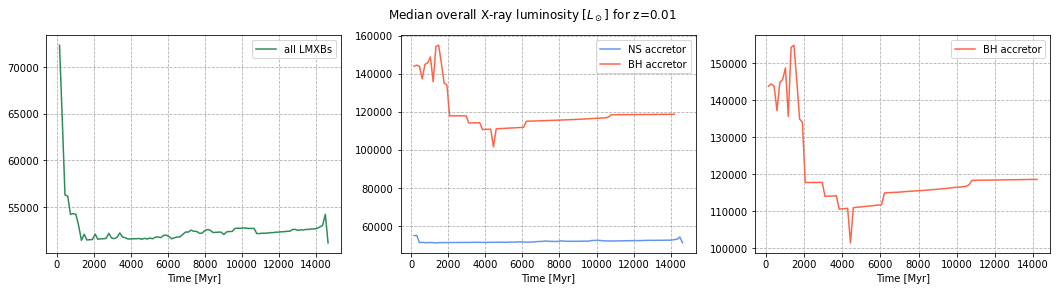

In [31]:
def median_for_timestep(df, timestep):
    return df.loc[(df['end_time']>=timestep) & (df['start_time']<=timestep)]['luminosity'].median()

plot_statistics(median_for_timestep, lmxb_sorted, lmxb_sorted_ns, lmxb_sorted_bh)
plt.suptitle('Median LMXB X-ray luminosity [$L_\odot$] for z=0.01')

plot_statistics(median_for_timestep, hmxb_sorted, hmxb_sorted_ns, hmxb_sorted_bh)
plt.suptitle(f'Median HMXB X-ray luminosity [$L_\odot$] for z=0.01')

plot_statistics(median_for_timestep, xb_sorted, xb_sorted_ns, xb_sorted_bh)
plt.suptitle(f'Median overall X-ray luminosity [$L_\odot$] for z=0.01')

Text(0.5, 0.98, 'Median overall starting accretor mass [$M_\\odot$] for z=0.01')

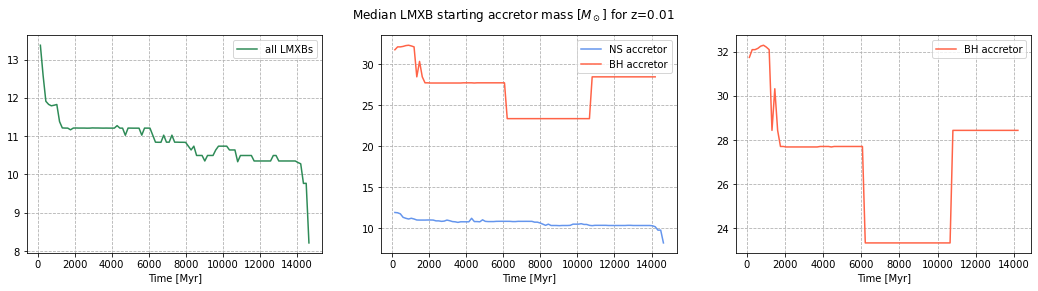

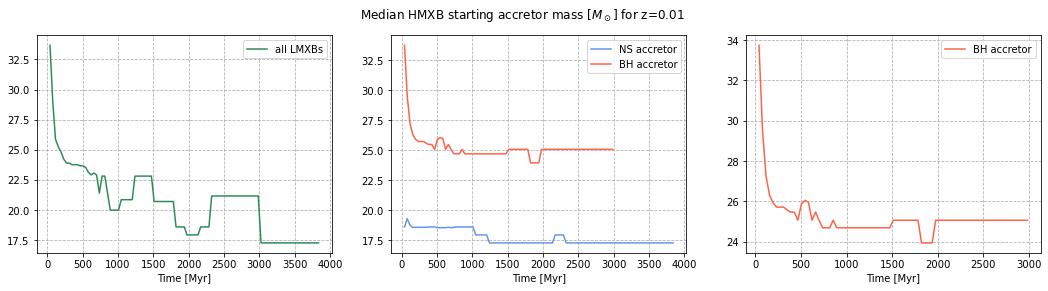

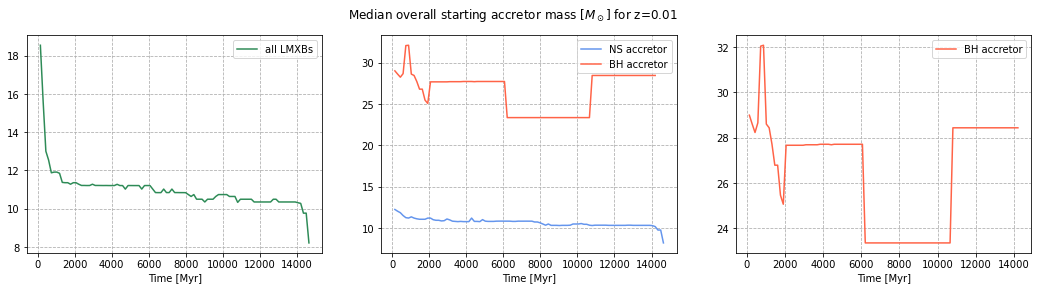

In [32]:
def median_accretor_mass_for_timestep(df, timestep):
    return df.loc[(df['end_time']>=timestep) & (df['start_time']<=timestep)]['start_acceptor_mass'].median()

plot_statistics(median_accretor_mass_for_timestep, lmxb_sorted, lmxb_sorted_ns, lmxb_sorted_bh)
plt.suptitle('Median LMXB starting accretor mass [$M_\odot$] for z=0.01')

plot_statistics(median_accretor_mass_for_timestep, hmxb_sorted, hmxb_sorted_ns, hmxb_sorted_bh)
plt.suptitle(f'Median HMXB starting accretor mass [$M_\odot$] for z=0.01')

plot_statistics(median_accretor_mass_for_timestep, xb_sorted, xb_sorted_ns, xb_sorted_bh)
plt.suptitle(f'Median overall starting accretor mass [$M_\odot$] for z=0.01')

## LMXB vs HMXB

In [33]:
def plot_statistics_lmxb_vs_hmxb(stat_fun, sorted_df, lmxb_df, hmxb_df):
    timesteps = np.linspace(0, sorted_df['end_time'].max(), 100)
    counts = [stat_fun(sorted_df, x) for x in timesteps]

    lmxb_counts = [stat_fun(lmxb_df, x) for x in timesteps]
    hmxb_counts = [stat_fun(hmxb_df, x) for x in timesteps]

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

    ax[0].plot(timesteps, counts, label='all XBs', color='seagreen')
    ax[0].grid(linestyle='--')
    ax[0].legend()
    ax[0].set_xlabel('Time [Myr]')

    ax[1].plot(timesteps, lmxb_counts, label='LMXB', color='cadetblue')
    ax[1].plot(timesteps, hmxb_counts, label='HMXB', color='palevioletred')
    ax[1].grid(linestyle='--')
    ax[1].legend()
    ax[1].set_xlabel('Time [Myr]')

Text(0.5, 0.98, 'Number of XBs for=0.02')

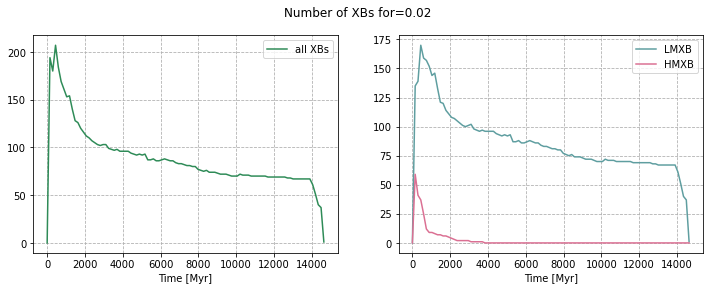

In [34]:
plot_statistics_lmxb_vs_hmxb(count_values_for_timestep, xb, lmxb_sorted, hmxb_sorted)
plt.suptitle(f'Number of XBs for=0.02')

Text(0.5, 0.98, 'Median X-ray luminosity [$L_\\odot$] for z=0.01')

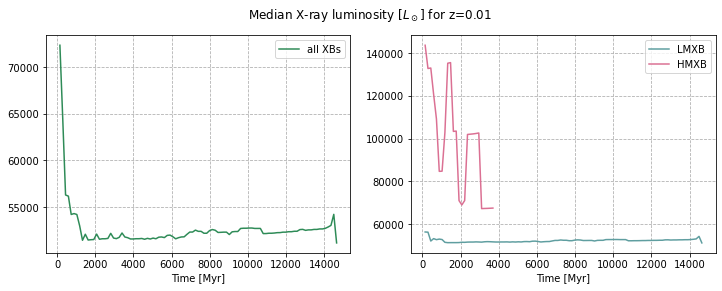

In [35]:
plot_statistics_lmxb_vs_hmxb(median_for_timestep,  xb, lmxb_sorted, hmxb_sorted)
plt.suptitle(f'Median X-ray luminosity [$L_\odot$] for z=0.01')

Text(0.5, 0.98, 'Median starting accretor mass [$M_\\odot$] for z=0.01')

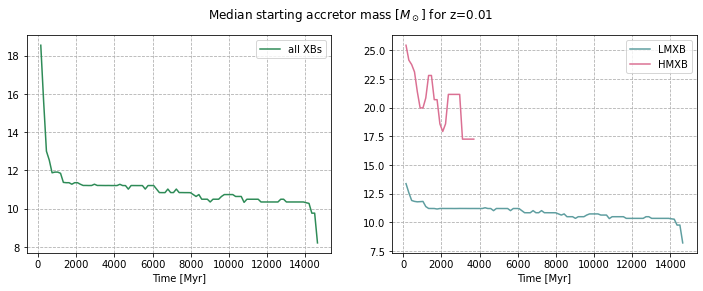

In [36]:
plot_statistics_lmxb_vs_hmxb(median_accretor_mass_for_timestep,  xb, lmxb_sorted, hmxb_sorted)
plt.suptitle(f'Median starting accretor mass [$M_\odot$] for z=0.01')

# Luminosity cumulative plots

In [37]:
xb['luminosity'].describe()

count    2.391300e+04
mean     1.463715e+05
std      1.563386e+05
min      4.435200e+04
25%      4.709752e+04
50%      7.721980e+04
75%      1.649295e+05
max      1.009661e+06
Name: luminosity, dtype: float64

In [38]:
luminosity_bins = np.arange(40000, 400000, 20000)

In [39]:
def cumulative_luminosity(df):
    df_sorted_by_lum = df.sort_values(by='luminosity')
    data = []
    for lbin in luminosity_bins:
        data.append([lbin, len(df_sorted_by_lum.loc[df_sorted_by_lum['luminosity']>=lbin].index)])
    return pd.DataFrame(data, columns=['min_luminosity', 'binaries'])
        

Text(0.5, 0.98, 'HMXBs')

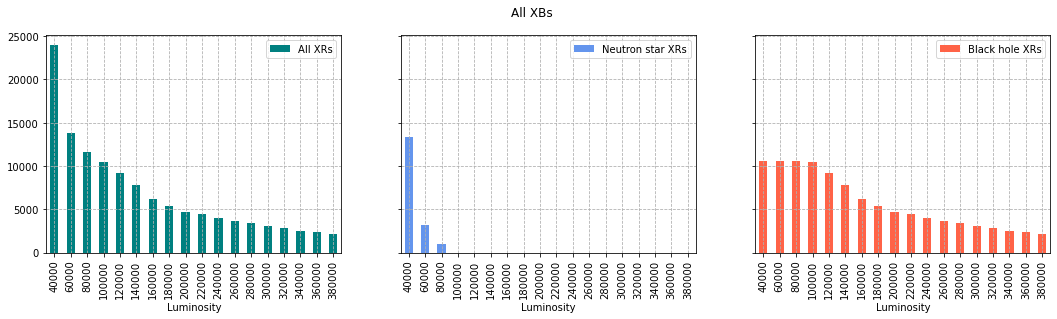

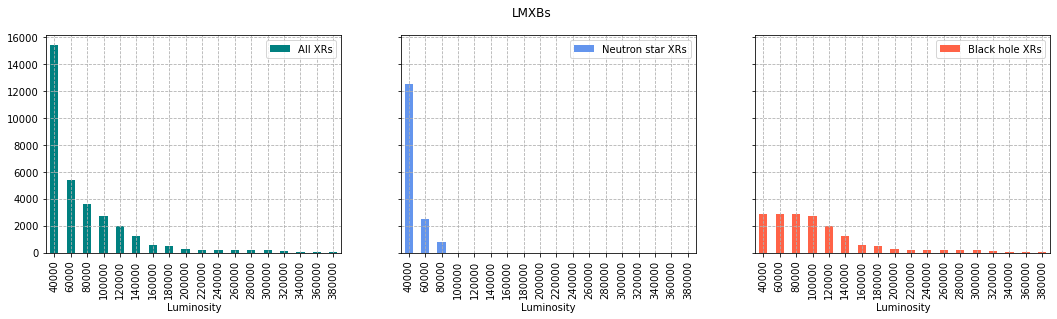

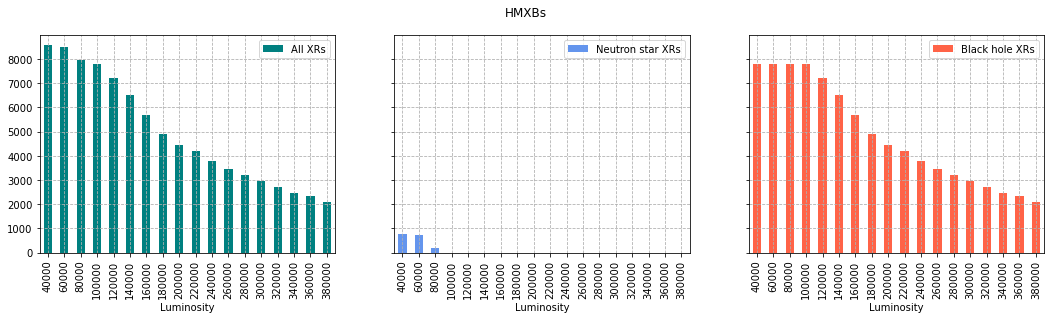

In [40]:
def plot_cumulative_luminosity(df, df_ns, df_bh):
    fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

    cumulative_luminosity(df).plot.bar(x='min_luminosity', y='binaries', color='teal', ax=ax[0], label='All XRs')
    ax[0].grid(linestyle='--')
    ax[0].set_xlabel('Luminosity')

    cumulative_luminosity(df_ns).plot.bar(x='min_luminosity', y='binaries', color='cornflowerblue', ax=ax[1], label='Neutron star XRs')
    ax[1].grid(linestyle='--')
    ax[1].set_xlabel('Luminosity')

    cumulative_luminosity(df_bh).plot.bar(x='min_luminosity', y='binaries', color='tomato', ax=ax[2], label='Black hole XRs')
    ax[2].grid(linestyle='--')
    ax[2].set_xlabel('Luminosity')
    
plot_cumulative_luminosity(xb, xb_sorted_ns, xb_sorted_bh)
plt.suptitle('All XBs')

plot_cumulative_luminosity(lmxb, lmxb_sorted_ns, lmxb_sorted_bh)
plt.suptitle('LMXBs')

plot_cumulative_luminosity(hmxb, hmxb_sorted_ns, hmxb_sorted_bh)
plt.suptitle('HMXBs')

## For specified timesteps

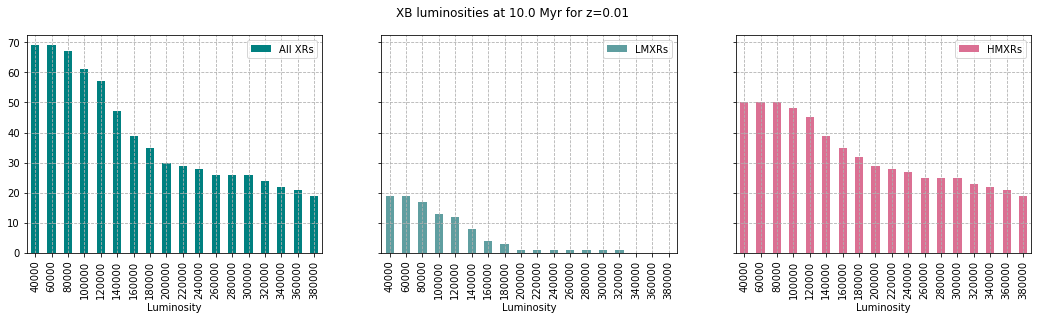

In [41]:
def plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, timestep):
    fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    
    fig.suptitle(f'XB luminosities at {timestep} Myr for z=0.01')
    
    lxmb_for_timestep = lmxb[(lmxb['start_time']<=timestep) & (lmxb['end_time']>=timestep)]
    hxmb_for_timestep = hmxb[(hmxb['start_time']<=timestep) & (hmxb['end_time']>=timestep)]
    xb_for_timestep = pd.concat([lxmb_for_timestep, hxmb_for_timestep])

    cumulative_luminosity(xb_for_timestep).plot.bar(x='min_luminosity', y='binaries', color='teal', ax=ax[0], label='All XRs')
    ax[0].grid(linestyle='--')
    ax[0].set_xlabel('Luminosity')

    cumulative_luminosity(lxmb_for_timestep).plot.bar(x='min_luminosity', y='binaries', color='cadetblue', ax=ax[1], label='LMXRs')
    ax[1].grid(linestyle='--')
    ax[1].set_xlabel('Luminosity')

    cumulative_luminosity(hxmb_for_timestep).plot.bar(x='min_luminosity', y='binaries', color='palevioletred', ax=ax[2], label='HMXRs')
    ax[2].grid(linestyle='--')
    ax[2].set_xlabel('Luminosity')
    
plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, 10.)

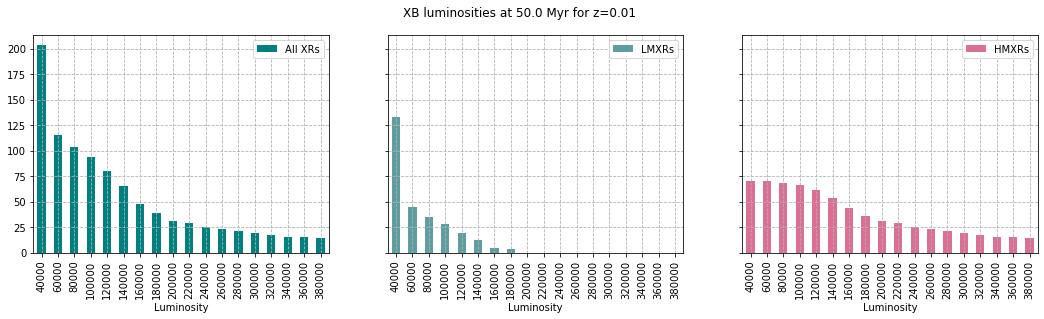

In [42]:
plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, 50.)

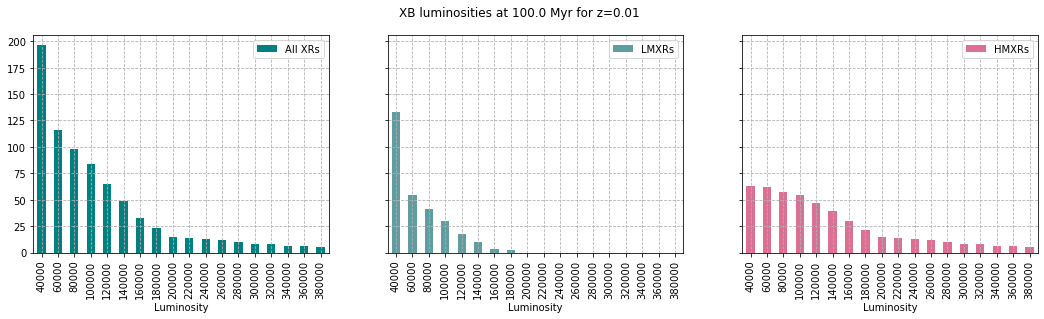

In [43]:
plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, 100.)

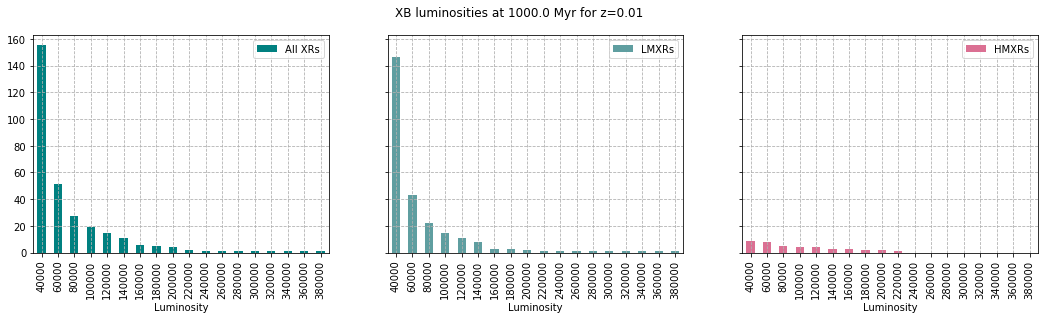

In [44]:
plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, 1000.)

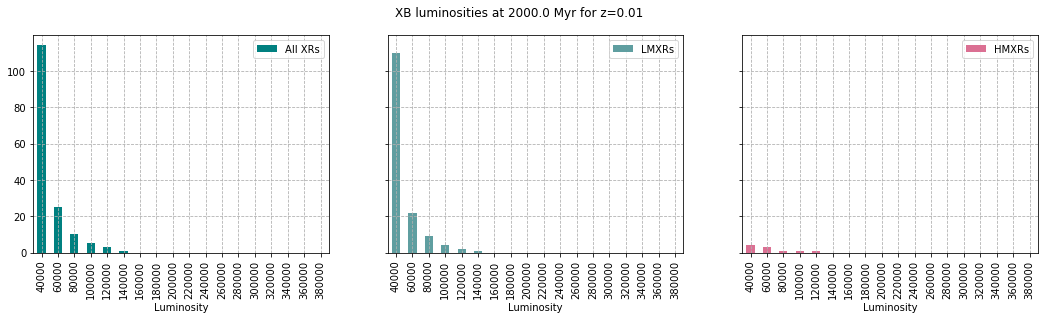

In [45]:
plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, 2000.)

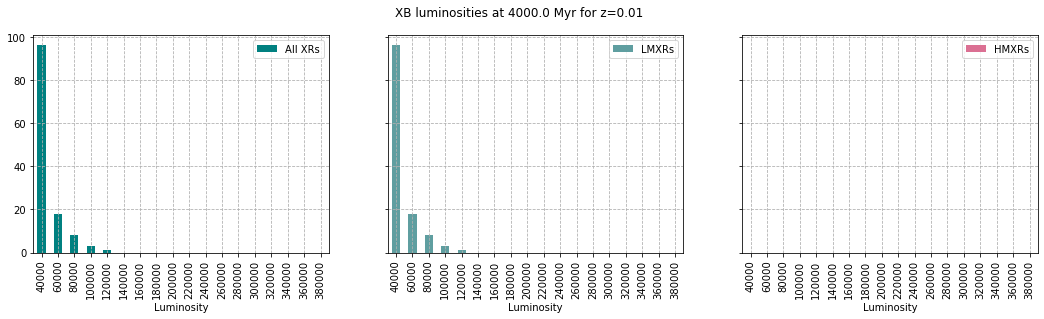

In [46]:
plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, 4000.)

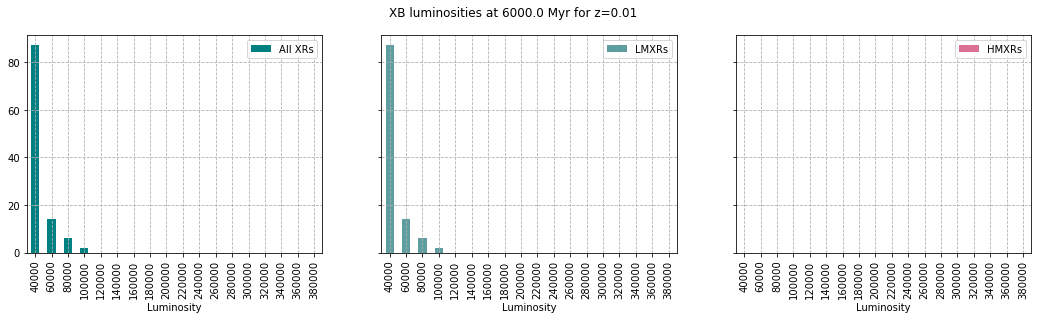

In [47]:
plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, 6000.)

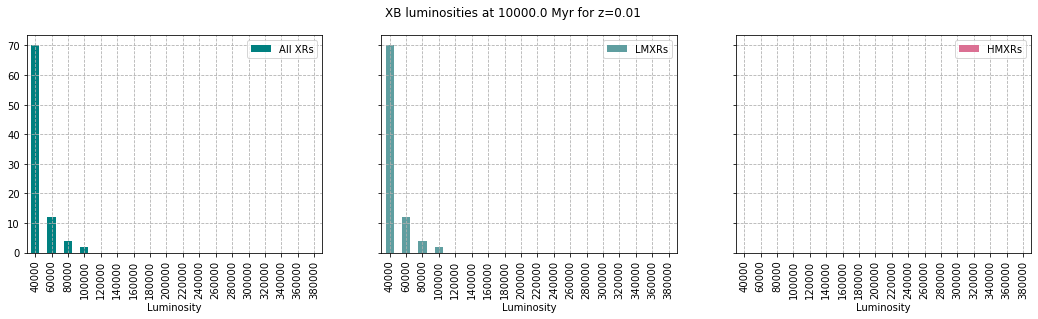

In [48]:
plot_lmxb_hmxb_cumulative_luminosity_for_timestep(lmxb, hmxb, 10000.)